## Simulated data and ABC-MCMC

We simulate parallax and parallax error for the DBSCAN-selected stars within a cluster in order to test the aprroximate Bayesian computation (ABC) <br>

For the simulated data the **input parameters** are: <br>
 * D_c     : Cluster distance 
 * N_s     : Star numbers
 * sigma_x : X physical standard deviation of the cluster
 * err_p : distribution to simulate the parallax error on each star
 
 
The **output products** will be:
 * Array of N points with:
     * simulated parallax
     * simulated parallax error
     
The ABC/MCMC method to estimate distance and sigma_x is implemented to be tested on simulated data

In [1]:
#### package and types
####
using Random ,  Distributions , Statistics
using PyPlot

## type starCluster
mutable struct starCluster
    xpos::Array{Float64}    ## x position
    ypos::Array{Float64}    ## y position
    zpos::Array{Float64}    ## z position
    sigma_x::Float64        ## std position
    sigma_y::Float64
    sigma_z::Float64
    ns::Int32               ## star number
    dc::Float64             ## cluster distance
end

## GAIA observations
mutable struct simGaia
    parallax::Array{Float64}
    parallax_err::Array{Float64}
end

## MCMC
mutable struct model
    distance::Float64
    sigmax::Float64
end

mutable struct mc
    distance::Array{Float64}
    sigmax::Array{Float64}
end

struct abc
    nstars::Int
    distancem::Float64
    distancedisp::Float64
    sigmaxm::Float64
    sigmaxdisp::Float64
    niter::Int
    nburnin::Int
    eps::Float64
end

┌ Info: Recompiling stale cache file /home/stephane/.julia/compiled/v1.0/Distributions/xILW0.ji for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1184


In [2]:
### data simulation

function create_cluster(ns = 1000 , dc = 380. , sigma_x = 1.6 , sigma_y = 1.5 , sigma_z = 1.0 )::starCluster
    xx = Normal(0.0, sigma_x)
    yy = Normal(0.0, sigma_y)
    zz = Normal(0.0, sigma_z)
    cluster = starCluster(zeros(ns) ,zeros(ns), zeros(ns), sigma_x , sigma_y, sigma_z, ns, dc)
    cluster.xpos = rand(xx, ns)
    cluster.ypos = rand(yy, ns)
    cluster.zpos = rand(zz, ns)
    
    return(cluster)
end

function create_gaia(c::starCluster, stderr, minerr)::simGaia
    gaia = simGaia(zeros(c.ns) , zeros(c.ns))
    
    err = TruncatedNormal(0.0, stderr, minerr , 1e9)
    gaia.parallax_err = rand(err, c.ns)
    
    #actual error draw from the error distribution
    actualErr = zeros(c.ns)
    for i in 1:c.ns
        errd = Normal(0.0, gaia.parallax_err[i])
        actualErr[i] = rand(errd)
    end
    
    gaia.parallax = 1000. ./ ( c.dc .+ c.xpos) .+ actualErr
    
    return(gaia)
end

create_gaia (generic function with 1 method)

In [3]:
function plot_simul(c::starCluster, distance)
    fig = figure(figsize=(10,8))

    ax = subplot(221)
    grid("on")
    scatter(c.xpos , c.ypos, s = 0.5 )
    xlabel("X")
    ylabel("Y")
    
    ax = subplot(222)
    grid("on")
    scatter(c.ypos , c.zpos, s = 0.5 )
    xlabel("Y")
    ylabel("Z")
    
    ax = subplot(223)
    grid("on")
    scatter(c.xpos , distance, s = 0.5 )
    xlabel("X")
    ylabel("Distance")

    show()
end

function plot_mcmc(mci::mc, actual_value)
    fig = figure(figsize=(10,5))
    
    ax = subplot(121)
    nbins = 50
    h , bins, patches  = plt[:hist](mci.distance, nbins, color = "g", alpha=0.4)
    hmax = maximum(h)
    pdist = 0.
    for i in 1:length(h)
        if h[i] == hmax  pdist = bins[i] end
    end
    xlabel("Distance")
    
    ax = subplot(122)
    nbins = 50
    h , bins, patches = plt[:hist](mci.sigmax,nbins, color = "r", alpha=0.4)
    hmax = maximum(h)
    pdisp = 0.
    for i in 1:length(h)
        if h[i] == hmax  pdisp = bins[i] end
    end    
    xlabel("σx")  
    
    show()
    return(pdist,pdisp)
end

plot_mcmc (generic function with 1 method)

In [4]:
#### model and model iteration
####
function theta(p::abc)
    pd      = TruncatedNormal(p.distancem, p.distancedisp, 0.001, 10000)
    psigmax = TruncatedNormal(p.sigmaxm, p.sigmaxdisp, 0.001, 10000.)
    
    distance = rand(pd)       ; pdist = pdf(pd,distance)
    sigmax   = rand(psigmax)  ; psig  = pdf(psigmax , sigmax)
    
    ptotal = pdist * psig
    params    = model(distance , sigmax)
    return(params , ptotal)
end

function theta_iter(θi::model , p::abc)
        pd      = TruncatedNormal(p.distancem, p.distancedisp, 0.001, 10000)
        psigmax = TruncatedNormal(p.sigmaxm, p.sigmaxdisp, 0.001, 10000.)
    
        d_rw          = TruncatedNormal(θi.distance , 10.0 , 0.001, 10000.)
        sigmax_rw     = TruncatedNormal(θi.sigmax , 5.0 , 0.0001, 10000.)
    
        new_dist   = rand(d_rw)        ;  pdist = pdf(pd, new_dist)
        new_sigmax = rand(sigmax_rw)   ;  psig  = pdf(psigmax , new_sigmax)
        
        ptotal = pdist * psig
        params  = model(new_dist , new_sigmax)
        return(params, ptotal)
end

theta_iter (generic function with 1 method)

In [5]:
### fitness from simulations compared to data
### psdata[1] = median(parallax)
### psdata[2] = std(parallax)

function fitness(m::model , params::abc , psdata, para_err)
    
    pxsimul = Normal(m.distance, m.sigmax)
    xsimul  = rand(pxsimul, params.nstars)
    
    err = TruncatedNormal(0.0, 0.011, 0.12 , 1e9)
    error = rand(err, params.nstars)
    
    #actual error draw from the error distribution
    actualErr = zeros(params.nstars)
    for i in 1:params.nstars
        errd = Normal(0.0, error[i])
        actualErr[i] = rand(errd)
    end    
    
    parallax_simul  = ( 1000. ./ xsimul )  .+ actualErr
    actual_distance = 1000. ./ parallax_simul
    
    ps1 = median(actual_distance)
    ps2 = std(actual_distance)
    fit = ((ps1 - psdata[1]) / psdata[1])^2 + ((ps2 - psdata[2]) / psdata[2])^2
    
    #println(ps1, "  ", psdata[1], "   " , ps2, "   ", psdata[2], "  " , fit)
    return(fit)    
end




fitness (generic function with 1 method)

In [6]:
function abc_mcmc(params::abc , gaia::simGaia)
    let
        mci       = mc(zeros(Float64,0),zeros(Float64,0))
        mi        = model(0. , 0.)
        micurrent = model(0. , 0.)
        probi = 0.
        probcurrent = 0.
        si = 0.
        sicurrent = 0.
        niter = params.niter
        nburn = params.nburnin
        initfound = false
        psdata = [0., 0.]
        dist = 1000. ./ gaia.parallax
        psdata[1] = median(dist)
        psdata[2] = std(dist)
        
        ### initialisation
        mi, probi = theta(params)
        si = fitness(mi , params ,  psdata , gaia.parallax_err)
        
        nchain = 1
        burndone = false
        loopagain = true
        while loopagain
            micurrent, probcurrent = theta_iter(mi , params)
            sicurrent = fitness(micurrent , params ,  psdata, gaia.parallax_err)
            
            if  sicurrent < params.eps
                α = probcurrent / probi
                if α > rand() 
                    mi = micurrent
                    probi = probcurrent
                    si = sicurrent
                    nchain += 1
                    if (nchain%1000 == 0) println("### chain:",nchain) end
                    if nchain > nburn && !burndone println("### burnin done...") ; nchain = 0 ; burndone = true end
                    if nchain > niter loopagain = false end
                    if burndone
                        push!(mci.distance, mi.distance)
                        push!(mci.sigmax, mi.sigmax)
                    end
                else
                    nchain += 1
                    if (nchain%1000 == 0) println("### chain:",nchain) end
                    if nchain > nburn && !burndone println("### burnin done...") ; nchain = 0 ; burndone = true end
                    if nchain > niter loopagain = false end
                    if burndone
                        push!(mci.distance, mi.distance)
                        push!(mci.sigmax, mi.sigmax)
                    end 
                end
            end
        end
        println("## ABC/MCMC done")
        println("##")
        return(mci)          
    end
end

abc_mcmc (generic function with 1 method)

Median distance on simulated data:374.91212196066357
Dispersion distance on simulated data:17.65694221565888
##
## Running ABC/MCMC on the distance
### burnin done...
### chain:1000
### chain:2000
### chain:3000
### chain:4000
### chain:5000
### chain:6000
### chain:7000
### chain:8000
### chain:9000
### chain:10000
### chain:11000
### chain:12000
### chain:13000
### chain:14000
### chain:15000
### chain:16000
### chain:17000
### chain:18000
### chain:19000
### chain:20000
## ABC/MCMC done
##
## Distance:374.99639127668104
## σx:4.082633037803999


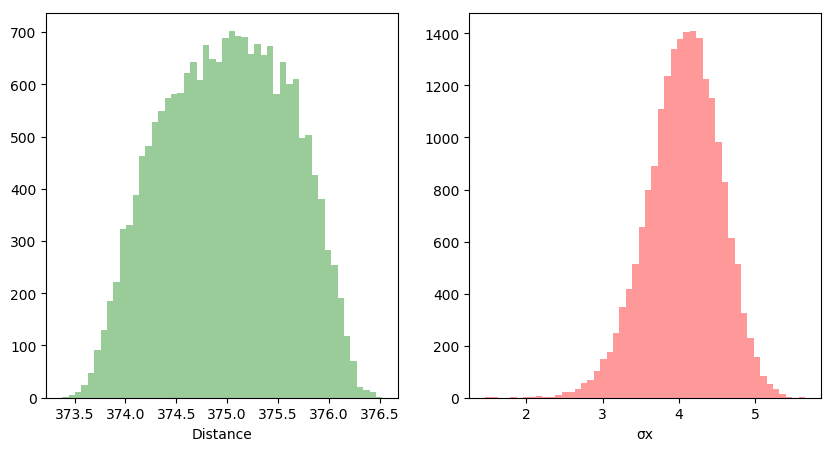

## Distance most likely:375.0153418979685
## Dispersion most likely:4.141813899181507


In [7]:
## Main program
## 

function main(params::abc, gaia::simGaia , actual_value)
    println("##")
    println("## Running ABC/MCMC on the distance")
    
    res = abc_mcmc(params, gaia)
    
    println("## Distance:", mean(res.distance))
    println("## σx:", median(res.sigmax))
    
    pdist, pdisp = plot_mcmc(res, actual_value)
    println("## Distance most likely:", pdist)
    println("## Dispersion most likely:", pdisp)
end

########################################
Random.seed!(123)

c1   = create_cluster(20000, 375.,  3.5 , 1.7, 1.0)
gaia = create_gaia(c1, 0.011 , 0.12)
d  = 1000. ./ gaia.parallax
    
# plot_simul(c1 , d)
println("Median distance on simulated data:",median(d))
println("Dispersion distance on simulated data:",std(d))

## ABC parameters
nstars = 20000
distancem = 400.
distancedisp = 40.
sigmaxm    = 5.0
sigmaxdisp = 10.0
niter = 20000
nburnin = 500
ϵ = 0.00001

pinit = abc(nstars , distancem, distancedisp , sigmaxm , sigmaxdisp , niter, nburnin , ϵ)

main(pinit, gaia, [420.,5.])